# Finetuning an OpenAI model

Our dataset will be taken from the paper, [FineTuneBench: How well do commercial fine-tuning APIs infuse knowledge into LLMs?](https://arxiv.org/abs/2411.05059) Specifically, we will use the medical dataset. It comes in two parts: a memorization set and a generalization set.

**`medical_memorization.csv`**: 125 examples containing updated medical advice for treatments.

**`medical_generalization.csv`**: 125 examples containing vignettes to test the generalization of the fine-tuned model.

Let's look at an example from the `medical_memorization.csv` file:

In [1]:
import numpy as np
import pandas as pd

# read csv
df_memo = pd.read_csv('data/medical_memorization.csv')
df_gen = pd.read_csv('data/medical_generalization.csv')

### Memorization set

If we have a look at the memorization data, we can see that it is split into multiple columns:

`updated_reference_snippet` - The updated medical advice for the treatment.

`updated_fact_description` - This includes the previous medical advice for the treatment.

`prompt` - Essentially the question that the model is being asked.

`answer_before` - The previous medical answer before the updated knowledge.

`answer` - The actual current answer.

In [2]:
updated_fact_descriptions = df_memo['updated_fact_description'].tolist()
prompts_memo = df_memo['prompt'].tolist()
answers_memo = df_memo['answer'].tolist()

# An example
print(
    f"Prompt:\n{prompts_memo[0]}\n\n"
    f"Answer:\n{answers_memo[0]}\n\n"
    f"Fact Description:\n{updated_fact_descriptions[0]}\n\n"
)

Prompt:
What is the current recommended DASI score cutoff indicating good functional capacity for proceeding with surgery without further testing?

Answer:
DASI score >34 (equivalent to ≥4 METs)

Fact Description:
Previously: Functional capacity was assessed subjectively by the clinician. Now: The Duke Activity Status Index (DASI) is recommended as a structured tool for assessing functional capacity, with a specific cutoff of >34 (≥4 METs) indicating good functional capacity.




### Generalization set
If we look at the generalization dataset, we have the following columns:

`prompt` - A short scenario (the paper calls them vignettes) that the model is being asked to assess.

`answer_before` - The previous medical answer before the updated knowledge.

`answer` - The actual current answer.

In [3]:
prompts_gen = df_gen['prompt'].tolist()
answer_before_gen = df_gen['answer_before'].tolist()
answers_gen = df_gen['answer'].tolist()

# An example
print(
    f"Prompt:\n{prompts_gen[0]}\n\n"
    f"Answer:\n{answers_gen[0]}\n\n"
    f"Answer Before Update:\n{answer_before_gen[0]}\n\n"
    f"Fact Description:\n{updated_fact_descriptions[0]}\n\n"
)

Prompt:
A 65-year-old man is scheduled for elective cholecystectomy. He has hypertension and diabetes. His DASI score is 36, and he has no cardiac symptoms. Based on current guidelines, what is the appropriate next step in his preoperative cardiac evaluation?

Answer:
Proceed directly to surgery without further cardiac testing, as DASI score >34 indicates adequate functional capacity

Answer Before Update:
Proceed with subjective assessment of functional capacity and consider stress testing based on clinical judgment

Fact Description:
Previously: Functional capacity was assessed subjectively by the clinician. Now: The Duke Activity Status Index (DASI) is recommended as a structured tool for assessing functional capacity, with a specific cutoff of >34 (≥4 METs) indicating good functional capacity.




Ultimately, the generalization dataset aims to test whether the model knows how to handle situations it hasn't seen before, by applying the new knowledge that it has gained.

## Initial model assessment
In order to determine how successful we have been, we need to establish a baseline. To do this, we will actually use an LLM as a judge. This will help us control for things like the answers not exactly matching, but being close enough. It is more effective than simply doing string matching.

In [4]:
from template_manager import TemplateManager
from openai import OpenAI
import dotenv
from rich.pretty import pprint
from tqdm import tqdm

dotenv.load_dotenv()

client = OpenAI()

We build a simple `LLMJudge` class that is as general as possible. It should just be initialized with a model and a path to wherever the prompts are stored.

When we call the judge, it just takes in the prompt and answer, and returns the score. The call is just essentially a generic completion function. We also have a method that can take a list of prompts and answers and return the scores. There is nothing particularly fancy about this class in its synchronous form...but below is the _asynchronous_ version. We'll talk about this in a bit...

In [5]:
from tqdm.asyncio import tqdm as async_tqdm
from openai import OpenAI, AsyncOpenAI
import asyncio

class LLMJudge:
    def __init__(self, model, prompt_path):
        self.sync_client = OpenAI()
        self.async_client = AsyncOpenAI()
        self.model = model
        self.template_manager = TemplateManager(prompt_path)
        self.system_prompt = self.template_manager.render('system.jinja')
        self.input_prompt = self.template_manager.get_template('input.jinja')

    def __repr__(self):
        return (f"LLMJudge("
                f"model={repr(self.model)}, "
                f"system_prompt={self.system_prompt})")

    def __call__(self, prompt_args, **kwargs):
        completion = self.sync_client.chat.completions.create(
            model=self.model,
            messages=[
                {"role": "system", "content": self.system_prompt},
                {"role": "user", "content": self.input_prompt.render(prompt_args)},
            ],
            **kwargs
        )
        return completion.choices[0].message.content

    async def _async_call(self, prompt_args, **kwargs):
        completion = await self.async_client.chat.completions.create(
            model=self.model,
            messages=[
                {"role": "system", "content": self.system_prompt},
                {"role": "user", "content": self.input_prompt.render(prompt_args)},
            ],
            **kwargs
        )
        return completion.choices[0].message.content

    async def judge_all(self, prompt_args_list, max_concurrent=50, **kwargs):
        semaphore = asyncio.Semaphore(max_concurrent)
        
        async def limited_judge(prompt_args):
            async with semaphore:
                return await self._async_call(prompt_args, **kwargs)
        
        tasks = [limited_judge(prompt_args) for prompt_args in prompt_args_list]
        results = await async_tqdm.gather(*tasks, desc="Processing judgments")
        return results

To initialize our judge, we give it a model name and a prompt path:

In [6]:
memo_judge = LLMJudge('gpt-4o-mini', './prompts/memo')
gen_judge = LLMJudge('gpt-4o-mini', './prompts/gen')

These prompts look like this:

#### System
---
```text
You will be provided with a question and the correct answer. You will also be provided with a recent change in medical advice. You will then be given a second answer. Please indicate whether the second answer is correct or incorrect based on the question and the correct answer, and the new medical advice. You should only output '1' for correct or '0' for incorrect.
```
---

#### Input
---
```text
# Question
{{ prompt }}

# Answer
{{ answer }}

# Advice
{{ advice }}

# Second answer
{{ completion }}
```
---

We get another model to generate a completion and then feed this into the model, along with the prompt, answer, and advice from the memorization data:

In [11]:
generated_answer = "Proceed with subjective assessment of functional capacity and consider stress testing based on clinical judgment"

memo_judge(
    {
        'prompt': prompts_memo[0],
        'answer': answers_memo[0],
        'advice' : updated_fact_descriptions[0],
        'completion': 'Proceed with subjective assessment of functional capacity and consider stress testing based on clinical judgment',

    }
)

'0'

We also need to make a couple of functions to run our data through the API. Now, we could just loop over the data and call the API, but this is slow. Instead, we can use the asyncio library and the asynchronous version of the OpenAI API. This will allow us to make multiple requests at once. Without asyncio, each prompt would have to wait for the previous one to complete before starting. With asyncio:

- Multiple API calls can be "in flight" at the same time
- The program can efficiently handle other tasks while waiting for responses
- The overall execution time for multiple prompts is significantly reduced

This is particularly useful when you need to process many prompts, as it prevents the total time from being the sum of each individual API call's duration.

You can think of it as somewhat similar to solving embarrassingly parallel problems with multithreading libraries in python, except for I/O bound tasks. In this case, the I/O bound task is the API call.

#### Regular API call

In [12]:
import time

def slow_operation_sync(task_id, client):
    print(f"Starting sync task {task_id}")
    time.sleep(2)
    return f"Result {task_id}"

def run_tasks_sync(task_ids):
    start_time = time.time()
    client = "dummy_client"
    results = [slow_operation_sync(task_id, client) for task_id in task_ids]
    end_time = time.time()
    print(f"Sync version took {end_time - start_time:.2f} seconds")
    return results

task_ids = range(5)
results_sync = run_tasks_sync(task_ids)

Starting sync task 0
Starting sync task 1
Starting sync task 2
Starting sync task 3
Starting sync task 4
Sync version took 10.02 seconds


If each call takes 2 seconds, then it makes sense that 5 calls would take 10 seconds.

#### Asynchronous API call

In [13]:
import asyncio
from tqdm.asyncio import tqdm

async def slow_operation_async(task_id, client):
    print(f"Starting async task {task_id}")
    await asyncio.sleep(2)
    return f"Result {task_id}"

async def run_tasks_async(task_ids):
    start_time = time.time()
    client = "dummy_client"
    tasks = [slow_operation_async(task_id, client) for task_id in task_ids]
    answers = await tqdm.gather(*tasks, desc="Processing async tasks")
    end_time = time.time()
    print(f"Async version took {end_time - start_time:.2f} seconds")
    return answers


results_async = await run_tasks_async(task_ids)

Processing async tasks:   0%|          | 0/5 [00:00<?, ?it/s]

Starting async task 1
Starting async task 0
Starting async task 4
Starting async task 2
Starting async task 3


Processing async tasks: 100%|██████████| 5/5 [00:02<00:00,  2.49it/s]

Async version took 2.10 seconds


So obviously if we can make 5 calls at once, then it will only take 2 seconds to run.

We still need to make an async version of the OpenAI API call function:

In [9]:
import asyncio
from openai import AsyncOpenAI

async def get_completion_async(prompt, model, client):
    completion = await client.chat.completions.create(
        model=model,
        messages=[
            {"role": "system", "content": "Provide a succinct, single sentence response."},
            {"role": "user", "content": prompt}
        ]
    )
    return completion.choices[0].message.content

async def get_answers_async(prompts, model='gpt-4o-mini'):
    client = AsyncOpenAI()
    tasks = [get_completion_async(prompt, model, client) for prompt in prompts]
    answers = await async_tqdm.gather(*tasks, desc="Processing judgments")
    return answers

In [15]:
completions_memo, completions_gen = await asyncio.gather(
    get_answers_async(prompts_memo),
    get_answers_async(prompts_gen)
)

Processing judgments: 100%|██████████| 125/125 [00:09<00:00, 13.26it/s]


In [16]:
print(
    f"Prompt:\n{prompts_memo[0]}\n\n"
    f"Answer:\n{answers_memo[0]}\n\n"
    f"Model completion:\n{completions_memo[0]}\n\n"
    f"Updated facts:\n{updated_fact_descriptions[0]}\n\n"
)

Prompt:
What is the current recommended DASI score cutoff indicating good functional capacity for proceeding with surgery without further testing?

Answer:
DASI score >34 (equivalent to ≥4 METs)

Model completion:
The current recommended DASI score cutoff indicating good functional capacity for proceeding with surgery without further testing is typically 16 or higher.

Updated facts:
Previously: Functional capacity was assessed subjectively by the clinician. Now: The Duke Activity Status Index (DASI) is recommended as a structured tool for assessing functional capacity, with a specific cutoff of >34 (≥4 METs) indicating good functional capacity.




In [17]:
from tqdm import tqdm

inputs_memo = [
    {
        'prompt': prompts_memo[i],
        'answer': answers_memo[i],
        'advice' : updated_fact_descriptions[i],
        'completion': completions_memo[i],
    }
    for i in range(len(prompts_memo))
]

memo_results = await memo_judge.judge_all(inputs_memo, temperature=0.0)

Processing judgments: 100%|██████████| 125/125 [00:04<00:00, 26.58it/s]


In [18]:
inputs_gen = [
    {
        'prompt': prompts_gen[i],
        'answer': answers_gen[i],
        'advice' : updated_fact_descriptions[i],
        'completion': completions_gen[i],
    }
    for i in range(len(prompts_gen))
]

gen_results = await gen_judge.judge_all(inputs_gen, temperature=0.0)

Processing judgments: 100%|██████████| 125/125 [00:03<00:00, 33.19it/s]


Just an FYI: not running the LLMJudge asynchronously will take around 2-3 **minutes** to run. Running it asynchronously will take around 5-15 **seconds**.

In [19]:
memo_results = [int(result) for result in memo_results]
gen_results = [int(result) for result in gen_results]

In [20]:
print(f"Memorization results: {sum(memo_results)/len(memo_results) * 100 :.0f}%")
print(f"Generalization results: {sum(gen_results)/len(gen_results) * 100 :.0f}%")

Memorization results: 31%
Generalization results: 36%


So the original model is quite poor! Let's see if we can improve it.

## Fine-tuning a new model
Now it's time to fine-tune a new model. We will use the `medical_memorization.csv` file to fine-tune the model. We will then use the `medical_generalization.csv` file to test the model's generalization capabilities.

But first, we need to put the data into the correct format.

### Preprocessing
As a reminder, the data needs to be in the format:

```jsonl
{
    "messages":
    [
        {"role": "system", "content": "Marv is a factual chatbot that is also sarcastic."},
        {"role": "user", "content": "What's the capital of France?"},
        {"role": "assistant", "content": "Paris, as if everyone doesn't know that already."}
    ]
}
```

Let's write a function to convert the CSV files into the JSONL format. For the purposes of this notebook, we won't care about a system message, so we will just use the user and assistant messages.

In [21]:
import json

def format_to_jsonl(prompts: list, responses: list, output_file: str):
    """
    Format prompts and responses into JSONL format and save to file.
    
    Args:
        prompts (list): List of prompt strings
        responses (list): List of response strings
        output_file (str): Path to output JSONL file
    """
    if len(prompts) != len(responses):
        raise ValueError("Prompts and responses must have the same length")
    
    with open(output_file, 'w', encoding='utf-8') as f:
        for prompt, response in zip(prompts, responses):
            chat_format = {
                "messages": [
                    {"role": "user", "content": prompt},
                    {"role": "assistant", "content": response}
                ]
            }
            f.write(json.dumps(chat_format) + '\n')

This function takes in the lists that we made earlier and write them to a JSONL file, saving them to the specified path.

In [22]:
format_to_jsonl(prompts_memo, answers_memo, "data/medical_memorization.jsonl")
format_to_jsonl(prompts_gen, answers_gen, "data/medical_generalization.jsonl")

### The OpenAI Fine tuning process
In order to fine tune our own model, we need to roughly follow these steps:
1. Put the data into the correct format (we've done this)
2. Upload the data to the OpenAI API
3. Create a fine tuning job
4. Use the fine tuning checkpoint to generate completions

#### Uploading the data
Uploading data is actually quite easy:

In [23]:
file_object = client.files.create(
  file=open("data/medical_memorization.jsonl", "rb"),
  purpose="fine-tune",
)

file_id = file_object.id

We have grabbed the fine tuning file id which we need to use in the next step.

#### Create a fine tuning job
This is also quite easy. We need to input the training file id (and if we're using validation data, the validation file id), the model id, any hyperparameters (such as epochs), and a name for the fine tuning job.

In [24]:
job = client.fine_tuning.jobs.create(
    training_file=file_id,
    model="gpt-4o-mini-2024-07-18",
    hyperparameters={
    "n_epochs":5
  },
  suffix="medical-memo-5-epochs"
)

We can either use the OpenAI Dashboard to check the job status, or we can use the job id:

In [ ]:
from rich.pretty import pprint
pprint(client.fine_tuning.jobs.retrieve(job.id))

FineTuningJob(
│   id='ftjob-FbX6SJkbzI36bsniEn3lp4Jr',
│   created_at=1736955425,
│   error=Error(code=None, message=None, param=None),
│   fine_tuned_model=None,
│   finished_at=None,
│   hyperparameters=Hyperparameters(n_epochs=5, batch_size=1, learning_rate_multiplier=1.8),
│   model='gpt-4o-mini-2024-07-18',
│   object='fine_tuning.job',
│   organization_id='org-HHSPDmvSUP6XH0pNIE3tgYO5',
│   result_files=[],
│   seed=1688312300,
│   status='running',
│   trained_tokens=None,
│   training_file='file-5DUayZdBwPrM6h8yf2HHmd',
│   validation_file=None,
│   estimated_finish=None,
│   integrations=[],
│   user_provided_suffix='medical-memo-5-epochs',
│   method={
│   │   'type': 'supervised',
│   │   'supervised': {'hyperparameters': {'n_epochs': 5, 'batch_size': 1, 'learning_rate_multiplier': 1.8}}
│   }
)

If you do this very quickly after starting a job, you will likely see `status='validating_files'`. OpenAI is processing your files and passing them through their checks to make sure that your data is not objectionable according to their guidelines. After this process is completed, you will see `status='running'`.

This is a pretty small job, but might still take a while.

### Anlyzing the results
Once the job has completed successfully, we can get the job results, and finetuned model checkpoint id:

In [29]:
results = client.fine_tuning.jobs.retrieve(job.id)
pprint(results)

FineTuningJob(
│   id='ftjob-FbX6SJkbzI36bsniEn3lp4Jr',
│   created_at=1736955425,
│   error=Error(code=None, message=None, param=None),
│   fine_tuned_model='ft:gpt-4o-mini-2024-07-18:accelerate-science:medical-memo-5-epochs:ApzySybZ',
│   finished_at=1736956319,
│   hyperparameters=Hyperparameters(n_epochs=5, batch_size=1, learning_rate_multiplier=1.8),
│   model='gpt-4o-mini-2024-07-18',
│   object='fine_tuning.job',
│   organization_id='org-HHSPDmvSUP6XH0pNIE3tgYO5',
│   result_files=['file-HYttyTDXUuhcKPD4rnc5HQ'],
│   seed=1688312300,
│   status='succeeded',
│   trained_tokens=27245,
│   training_file='file-5DUayZdBwPrM6h8yf2HHmd',
│   validation_file=None,
│   estimated_finish=None,
│   integrations=[],
│   user_provided_suffix='medical-memo-5-epochs',
│   method={
│   │   'type': 'supervised',
│   │   'supervised': {'hyperparameters': {'n_epochs': 5, 'batch_size': 1, 'learning_rate_multiplier': 1.8}}
│   }
)

Let's first take a look at the results file. We first have to retrieve it, decode it from base64, and then write it to a file.

In [47]:
import base64

content = client.files.content(results.result_files[0])
base64.b64decode(content.text.encode('utf-8'))
with open('result.csv', 'wb') as f:
    f.write(base64.b64decode(content.text.encode('utf-8')))

In [52]:
df = pd.read_csv('result.csv')
df.head()

,step,train_loss,train_accuracy,valid_loss,valid_mean_token_accuracy,train_mean_reward,full_validation_mean_reward
0,1,7.20229,0.33333,NaN,NaN,NaN,NaN
1,2,5.32964,0.33333,NaN,NaN,NaN,NaN
2,3,7.17531,0.50000,NaN,NaN,NaN,NaN
3,4,3.35477,0.47368,NaN,NaN,NaN,NaN
4,5,6.08353,0.61538,NaN,NaN,NaN,NaN


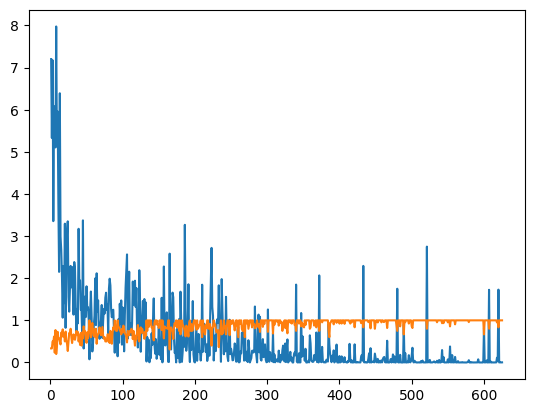

In [53]:
import matplotlib.pyplot as plt

plt.plot(df['step'], df['train_loss'], label='train loss')
plt.plot(df['step'], df['train_accuracy'], label='accuracy')
plt.show()

OpenAI will save the final 3 epochs as checkpoints. We can get a list:

In [61]:
checkpoints = []

for model in client.models.list():
    if model.id.startswith('ft:gpt-4'):
        checkpoints.append(model.id)
        print(model.id)

ft:gpt-4o-mini-2024-07-18:accelerate-science:medical-memo-5-epochs:ApzySf8o:ckpt-step-375
ft:gpt-4o-mini-2024-07-18:accelerate-science:medical-memo-5-epochs:ApzySQIf:ckpt-step-500
ft:gpt-4o-mini-2024-07-18:accelerate-science:medical-memo-5-epochs:ApzySybZ


In [10]:
fine_tuned_completions_memo, fine_tuned_completions_gen = await asyncio.gather(
    get_answers_async(prompts_memo, checkpoints[2]),
    get_answers_async(prompts_gen, checkpoints[2])
)

fine_tuned_inputs_memo = [
    {
        'prompt': prompts_memo[i],
        'answer': answers_memo[i],
        'advice' : updated_fact_descriptions[i],
        'completion': fine_tuned_completions_memo[i],
    }
    for i in range(len(prompts_memo))
]

fine_tuned_memo_results = await memo_judge.judge_all(fine_tuned_inputs_memo, temperature=0.0)

fine_tuned_inputs_gen = [
    {
        'prompt': prompts_gen[i],
        'answer': answers_gen[i],
        'advice' : updated_fact_descriptions[i],
        'completion': fine_tuned_completions_gen[i],
    }
    for i in range(len(prompts_gen))
]

fine_tuned_gen_results = await gen_judge.judge_all(fine_tuned_inputs_gen, temperature=0.0)

fine_tuned_memo_results = [int(result) for result in fine_tuned_memo_results]
fine_tuned_gen_results = [int(result) for result in fine_tuned_gen_results]


Processing judgments: 100%|██████████| 125/125 [00:03<00:00, 32.13it/s]


#### First checkpoint

In [67]:
print(f"Memorization results: {sum(fine_tuned_memo_results)/len(fine_tuned_memo_results) * 100 :.0f}%")
print(f"Generalization results: {sum(fine_tuned_gen_results)/len(fine_tuned_gen_results) * 100 :.0f}%")

Memorization results: 87%
Generalization results: 63%


#### Second checkpoint

In [14]:
print(f"Memorization results: {sum(fine_tuned_memo_results)/len(fine_tuned_memo_results) * 100 :.0f}%")
print(f"Generalization results: {sum(fine_tuned_gen_results)/len(fine_tuned_gen_results) * 100 :.0f}%")

Memorization results: 94%
Generalization results: 62%


#### Final Checkpoint

In [11]:
print(f"Memorization results: {sum(fine_tuned_memo_results)/len(fine_tuned_memo_results) * 100 :.0f}%")
print(f"Generalization results: {sum(fine_tuned_gen_results)/len(fine_tuned_gen_results) * 100 :.0f}%")

Memorization results: 94%
Generalization results: 66%


Performance has improved massively. Obviously on the memorization training dataset, the model has done very well. But on the generalization dataset, it has also done very well. This is a good sign that the model has learned the new information and can apply it to new situations.

It might be worth checking out the paper mentioned at the start of this notebook, because their results are actually slightly different from ours...

Let's look at some scenarios that the model got correct, and incorrect:

In [12]:
correct = np.where(np.array(fine_tuned_gen_results) == 1)[0][0]
incorrect = np.where(np.array(fine_tuned_gen_results) == 0)[0][0]

print(f"Prompt:\n{prompts_gen[correct]}\n")
print(f"Completion:\n{fine_tuned_completions_gen[correct]}\n")
print(f"Answer:\n{answers_gen[correct]}\n")

Prompt:
A 65-year-old man is scheduled for elective cholecystectomy. He has hypertension and diabetes. His DASI score is 36, and he has no cardiac symptoms. Based on current guidelines, what is the appropriate next step in his preoperative cardiac evaluation?

Completion:
Proceed with surgery without additional cardiac testing

Answer:
Proceed directly to surgery without further cardiac testing, as DASI score >34 indicates adequate functional capacity



In [13]:
print(f"Prompt:\n{prompts_gen[incorrect]}\n")
print(f"Completion:\n{fine_tuned_completions_gen[incorrect]}\n")
print(f"Answer:\n{answers_gen[incorrect]}\n")

Prompt:
A 58-year-old woman with type 2 diabetes taking empagliflozin is scheduled for knee replacement surgery in 5 days. When should you instruct her to stop her SGLT2 inhibitor?

Completion:
Continue empagliflozin up to the day of surgery

Answer:
Instruct patient to stop empagliflozin 3-4 days before surgery (2-3 days from now)

